# Data Science Job Posting Analysis Assignment

In this assignment we will work with a dataset that incudes information about Data Science scraped from Glassdoor. You will notice that in some cases the prompt in the assignment is a bit vague, and thats okay.

For each prompt write how you tackled the question / data cleaning task and any assumptions you made. Some questions can be interpreted differently and data cleaning can lead to different outcomes, so its perfectly okay for this assignment to have results different from your peers. Thats why its important to note your approach.

This assignment is meant to get you familar with Python, Pandas and visualization libraries (like matplotlib).


Name: `Ashish Kulkarni`

Email: `akulk050@ucr.edu`

Student ID: `862637808`

`AI Disclaimer`: No Generative AI tools (including code-completion and online chatbots like ChatGPT) were used in my solutions to this assignment, apart from the list of technologies in section 3.5 (generated by ChatGPT).

`References`: StackOverflow, Pandas documentation, matplotlib documentation

## Step 1: Load the Dataset and Import Libraries

This solution uses a synthetic dataset generated in the notebook to demonstrate the analyses. In practice, replace the generation step with `pd.read_csv()` or appropriate loader.

In [1]:
import re
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Load the CSV file (check filename from the print above)
df = pd.read_csv("DataScientist.csv")  # adjust if needed

# Display the first rows of the dataset
print('Dataset overview:')
df.head()

Dataset overview:


,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,TRUE
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


## Step 2: Data Cleaning

You will notice that data cleaning is required for this dataset due to inconsistences.


- Standardize column names (ex. lower case all column names)

- Parse `Salary Estimate` to extract numeric salary values (handle ranges, for example compute the average salary based on the low and high range provided)

- Deduplicate rows if necessary (duplicates are defined as repeated columns in each column)

- Determine columns with too many missing values. Note, some datasets have Nulls for missing values while others might use other characters or notations.

- Standarize job titles. For example, Sr. Data Scientist is equivalent to Senior Data Scientist but we cannot directly compare these two roles without some data cleaning on our part.

### TODO - Your explanations goes here

In [2]:
# Converting the column names to lowercase, and deleting the first two columns
df.rename(columns={column: column.lower() for column in df.columns}, inplace=True)

# deleting the first two columns (redundant index columns) (run this only once)
df = df.drop(columns=df.columns[:2], axis=1)

# We could use the drop_duplicates pandas DataFrame method, but I chose not to since a duplicate posting could pertain to an identical opening but in a different team at the organization, or just a different opening but within the same team.

#### Defining some functions to be used for data cleanup

In [3]:
def normalize_salary_range(s: str) -> tuple[float, float, str]:
    """Takes the natural language Salary Estimate column values (str) and maps them to the actual lower and upper bounds of the salary range, indicate the time period of the wage.
    
    Example inputs:
    - $73K-$136K (Glassdoor est.)
    - $10-$26 Per Hour(Glassdoor est.)
    - $73.5K-$136.2K (Glassdoor est.)

    Example output:
    - 73000, 136000, 'year'
    - 10, 26, 'hour'
    - 73500, 136200, 'year'"""

    min_salary, max_salary = s.split("-")[:2]
    
    def get_dollar_salary(s: str):
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 1, "Too many numbers found"
        salary = float(nums[0])
        if s.index(nums[0]) + len(nums[0]) < len(s):
            if s[s.index(nums[0]) + len(nums[0])] == "K":
                salary *= 1000
            elif s[s.index(nums[0]) + len(nums[0])] == "M":
                salary *= 1000000
            elif s[s.index(nums[0]) + len(nums[0])] == "B":
                salary *= 1000000000
        return salary
    
    min_salary = get_dollar_salary(min_salary)
    max_salary = get_dollar_salary(max_salary)

    if "hour" in s.lower():
        period = "hour"
    else:
        period = "year"

    return (min_salary, max_salary, period)


def salary_range_and_period_to_yearly_est(l: float, h: float, p: typing.Literal["hour", "year"]):
    """Return mean of yearly salary range. In case of hourly wage, assume 260 working days and 8 hours per day.
    
    Params:
        l (float): the lower bound of the salary range
        h (float): the upper bound of the salary range
        p (literal 'hour' or 'year'): the period of the salary figures mentioned"""
    
    return (l + h) / 2 * (8 * 260 if p == "hour" else 1)


def normalize_revenue_range(s: str) -> tuple[float, float, str]:
    """Given the company revenue range in the format present in the dataset, split into lower bound, upper bound, and currency of revenue values."""
        
    s = s.lower()
    
    if "less than" in s:
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 1, "Too many numbers found"
        max_revenue = float(nums[0])
        min_revenue = 0
        if "thousand" in s:
            max_revenue *= 1000
        elif "million" in s:
            max_revenue *= 1000000
        elif "billion" in s:
            max_revenue *= 1000000000
        elif "trillion" in s:
            max_revenue *= 100000000000
    elif "+" in s:
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 1, "Too many numbers found"
        max_revenue = float('inf')
        min_revenue = float(nums[0])
        if "thousand" in s:
            min_revenue *= 1000
        elif "million" in s:
            min_revenue *= 1000000
        elif "billion" in s:
            min_revenue *= 1000000000
        elif "trillion" in s:
            min_revenue *= 100000000000
    else:
        common_illion = False
        number_regex = r"\d*\.?\d+"
        nums = re.findall(number_regex, s)
        assert len(nums) == 2, "More or less than 2 numbers found"
        s1, s2 = s.split(" to ")

        r1s = re.findall(number_regex, s1)
        assert len(r1s) == 1, "Too many numbers found"
        min_revenue = float(r1s[0])
        if "thousand" in s1:
            min_revenue *= 1000
        elif "million" in s1:
            min_revenue *= 1000000
        elif "billion" in s1:
            min_revenue *= 1000000000
        elif "trillion" in s1:
            min_revenue *= 100000000000
        else:
            common_illion = True
        
        r2s = re.findall(number_regex, s2)
        assert len(r2s) == 1, "Too many numbers found"
        max_revenue = float(r2s[0])
        if "thousand" in s2:
            max_revenue *= 1000
            common_illion = (1 if not common_illion else 1000)
        elif "million" in s2:
            max_revenue *= 1000000
            common_illion = (1 if not common_illion else 1000000)
        elif "billion" in s2:
            max_revenue *= 1000000000
            common_illion = (1 if not common_illion else 1000000000)
        elif "trillion" in s2:
            max_revenue *= 100000000000
            common_illion = (1 if not common_illion else 1000000000000)
        
        min_revenue *= common_illion
    
    currency_pattern = r"\((.*)\)"
    currencies = re.findall(currency_pattern, s)
    assert len(currencies) == 1, "Could not isolate currency"
    currency = currencies[0].upper()
    
    return min_revenue, max_revenue, currency


def replace_common_abbreviations(s: str) -> str:
    abbrs = {
        "Sr.": "Senior",
        "Sr": "Senior",
        "SR.": "Senior",
        "Jr.": "Junior",
        "Jr": "Junior",
        "JR.": "Junior",
        "Dir.": "Director",
        "Dir": "Director",
        "DIR.": "Director",
    }
    s = s.split(" ")
    for i, w in enumerate(s):
        for abbr, full in abbrs.items():
            if w == abbr:
                s[i] = full
    return " ".join(s)

def job_title_cleaner(s: str) -> str:
    """Cleans job titles by:
    - Replacing common job title abbreviations
    - Removing text after a comma
    - Removing text after a hyphen
    - Removing text in parantheses"""

    return replace_common_abbreviations(s).split(", ")[0].split(" - ")[0].split(" (")[0]

#### Some case-by-case cleaning on individual columns

1. Replacing `-1`s with `None`s
    1. `Rating`
        Clearly, the -1 rating indicates that a rating does not exist for a company, since user ratings are measured between 1-5.
    2. `Headquarters`
    3. `Size`
        Obviously, -1 size does not indicate that negative one person works at the company, None would be better suited here.
    4. `Founded`
    6. `Industry`
    7. `Sector`
2.  Replacing `Unknown`s with `None`s
    1. `Type of Ownership`
3. Replacing `Unknown / Non-Applicable`s with `None`s
    1. `Revenue`
4. Converting the `Competitors` column into a list
5. Replacing `-1`s in `Easy Apply` with `False`, and `'TRUE'` with `True`
6. Some company names include their rating in the next line; removing them.
7. Cleaning job titles (into a new column to avoid data loss)
    1. Expanding common abbreviations in job titles
    2. Removing text after a comma (ex. `Sr Software Engineer, Python`)
    3. Removing text after a hyphen (ex. `Data Scientist - Forecasting`)
    4. Removing text in parantheses (ex. `Data Scientist/Engineer (SAS, R code, Python & Sql (Open to remote Workers))`)

In [4]:
df['rating'] = df['rating'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['headquarters'] = df['headquarters'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['size'] = df['size'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['founded'] = df['founded'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['industry'] = df['industry'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)
df['sector'] = df['sector'].replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)

df['type of ownership'] = df['type of ownership'].replace(to_replace="Unknown", value=None)

df['revenue'] = df['revenue'].replace(to_replace="Unknown / Non-Applicable", value=None).replace(to_replace=-1, value=None).replace(to_replace='-1', value=None)

df['competitors'] = df['competitors'].replace(to_replace=-1, value='').replace(to_replace='-1', value='')
df['competitors'] = df['competitors'].apply(func=lambda x: [c for c in x.split(", ") if c] if isinstance(x, str) else x)

df['easy apply'] = df['easy apply'].replace(to_replace=-1, value=False).replace(to_replace='-1', value=False).replace(to_replace='TRUE', value=True)

df['company name'] = df['company name'].apply(func=lambda x: x.split("\n")[0])

df['cleaned job title'] = df['job title'].apply(func=job_title_cleaner)

df

C:\Users\kulka\AppData\Local\Temp\ipykernel_9076\3071214042.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['easy apply'] = df['easy apply'].replace(to_replace=-1, value=False).replace(to_replace='-1', value=False).replace(to_replace='TRUE', value=True)


,job title,salary estimate,job description,rating,company name,location,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,easy apply,cleaned job title
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,None,[],False,Senior Data Scientist
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,None,[],False,Data Scientist
2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,None,Decode_M,"New York, NY","New York, NY",1 to 50 employees,None,None,None,None,None,[],True,Data Science Manager
3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,None,"[Zocdoc, Healthgrades]",False,Data Analyst
4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,None,"[BBDO, Grey Group, Droga5]",False,Director
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,AWS Data Engineer,$55K-$112K (Glassdoor est.),About Us\n\nTachyon Technologies is a Digital ...,4.4,Tachyon Technologies,"Dublin, OH","Irving, TX",201 to 500 employees,2011,Company - Private,IT Services,Information Technology,$10 to $25 million (USD),[],False,AWS Data Engineer
3905,Data Analyst â Junior,$55K-$112K (Glassdoor est.),"Job description\nInterpret data, analyze resul...",5.0,"Staffigo Technical Services, LLC","Columbus, OH","Woodridge, IL",51 to 200 employees,2008,Company - Private,IT Services,Information Technology,$50 to $100 million (USD),[],False,Data Analyst â Junior
3906,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),Job DescriptionThe Security Analytics Data Eng...,3.8,"PDS Tech, Inc.","Dublin, OH","Irving, TX",5001 to 10000 employees,1977,Company - Private,Staffing & Outsourcing,Business Services,$100 to $500 million (USD),[],False,Security Analytics Data Engineer
3907,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),The Security Analytics Data Engineer will inte...,4.0,Data Resource Technologies,"Dublin, OH","Omaha, NE",1 to 50 employees,None,Company - Private,Accounting,Accounting & Legal,Less than $1 million (USD),[],False,Security Analytics Data Engineer


#### Adding columns extracted from other columns

1. `Salary Estimate` → `Lower Salary Bound`, `Upper Salary Bound`, `Salary Per`, `Estimated Annual Salary`

In [5]:
df['lower salary bound'] = df['salary estimate'].apply(func=lambda x: normalize_salary_range(x)[0] if isinstance(x, str) else x)
df['upper salary bound'] = df['salary estimate'].apply(func=lambda x: normalize_salary_range(x)[1] if isinstance(x, str) else x)
df['salary per'] = df['salary estimate'].apply(func=lambda x: normalize_salary_range(x)[2] if isinstance(x, str) else x)
df.loc[df['salary per'] == 'year', 'average annual salary estimate'] = salary_range_and_period_to_yearly_est(df[df['salary per'] == 'year']['lower salary bound'], df[df['salary per'] == 'year']['upper salary bound'], 'year')
df.loc[df['salary per'] == 'hour', 'average annual salary estimate'] = salary_range_and_period_to_yearly_est(df[df['salary per'] == 'hour']['lower salary bound'], df[df['salary per'] == 'hour']['upper salary bound'], 'hour')

df['revenue range lower bound'] = df['revenue'].apply(func=lambda x: normalize_revenue_range(x)[0] if isinstance(x, str) else x)
df['revenue range upper bound'] = df['revenue'].apply(func=lambda x: normalize_revenue_range(x)[1] if isinstance(x, str) else x)
df['revenue currency'] = df['revenue'].apply(func=lambda x: normalize_revenue_range(x)[2] if isinstance(x, str) else x)

df[["cleaned job title", "salary estimate", "lower salary bound", "upper salary bound", "salary per", "company name", "revenue", "revenue range lower bound", "revenue range upper bound", "revenue currency"]].dropna(inplace=False)

,cleaned job title,salary estimate,lower salary bound,upper salary bound,salary per,company name,revenue,revenue range lower bound,revenue range upper bound,revenue currency
11,Data Scientist/Machine Learning,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,PulsePoint,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
12,Data Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,Medidata Solutions,$500 million to $1 billion (USD),5.000000e+08,1.000000e+09,USD
16,Data Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,Etsy,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
17,Data Scientist/ML Engineer,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,PA Consulting,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
18,Data Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,year,Etsy,$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
...,...,...,...,...,...,...,...,...,...,...
3904,AWS Data Engineer,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,Tachyon Technologies,$10 to $25 million (USD),1.000000e+07,2.500000e+07,USD
3905,Data Analyst â Junior,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,"Staffigo Technical Services, LLC",$50 to $100 million (USD),5.000000e+07,1.000000e+08,USD
3906,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,"PDS Tech, Inc.",$100 to $500 million (USD),1.000000e+08,5.000000e+08,USD
3907,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),55000.0,112000.0,year,Data Resource Technologies,Less than $1 million (USD),0.000000e+00,1.000000e+06,USD


#### Reordering columns for more clarity

In [6]:
desired_column_order = [
    "cleaned job title",
    "location",
    "lower salary bound",
    "upper salary bound",
    "salary per",
    "average annual salary estimate",
    "company name",
    "type of ownership",
    "industry",
    "sector",
    "competitors",
    "headquarters",
    "size",
    "founded",
    "revenue range lower bound",
    "revenue range upper bound",
    "revenue currency",
    "job description",
    "rating",
    "easy apply",
    "job title",
    "salary estimate",
    "revenue",
]
df = df[desired_column_order]

In [7]:
df.to_csv("ProcessedDataScientist.csv")

## Step 3: Exploratory Data Analysis (EDA)

### 3.1 Basic Overview
What are the top or most popular job titles?
What are the top companies (based on job posting)?
What are the top 5 industry sectors (based on job postings)?

We see that the top 10 job titles based on the input dataset are:
- Data Scientist
- Data Engineer
- Data Analyst
- Senior Data Scientist
- Machine Learning Engineer
- Senior Data Analyst
- Big Data Engineer
- Business Intelligence Analyst
- Senior Data Engineer
- Sr. Data Scientist

After merging jobs by expanding abbreviations (Jr, Sr, etc.) in job titles and applying other title cleaning methods, we notice that the top 10 are now different:
- Data Scientist
- Data Engineer
- Data Analyst
- Senior Data Scientist
- Senior Data Analyst
- Senior Data Engineer
- Machine Learning Engineer
- Scientist
- Senior Scientist
- Big Data Engineer

There are still some job titles (examples listed below) whose successful normalization could have changed the top 10.
- Data Scientist/Machine Learning
- AWS Data Engineer

Here is a pie chart that shows the distribution of the top 5 job titles in the dataset:


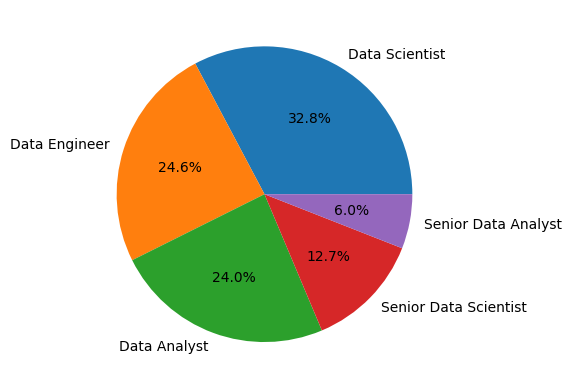

In [8]:
# Top job titles (look at 'Job Title' column). Generate a plot to visualize top 5 job titles based on the number of postings for that same job title.
top_job_titles_dict = df["job title"].value_counts().to_dict()  # in descending order of frequency
n = 10
print(f"We see that the top {n} job titles based on the input dataset are:\n- " + "\n- ".join(list(top_job_titles_dict.keys())[:n]), end="\n\n")
top_cleaned_job_titles_dict = df["cleaned job title"].value_counts().to_dict()
print(f"After merging jobs by expanding abbreviations (Jr, Sr, etc.) in job titles and applying other title cleaning methods, we notice that the top {n} are now different:\n- " + "\n- ".join(list(top_cleaned_job_titles_dict.keys())[:n]), end="\n\n")
print(f"There are still some job titles (examples listed below) whose successful normalization could have changed the top {n}.\n- Data Scientist/Machine Learning\n- AWS Data Engineer", end="\n\n")
n = 5
print(f"Here is a pie chart that shows the distribution of the top {n} job titles in the dataset:")
labels = list(top_cleaned_job_titles_dict.keys())[:n]  # + ["Others"]
sizes = list(top_cleaned_job_titles_dict.values())[:n]  # + [sum(list(top_cleaned_job_titles_dict.values())[n:])]
gig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.show()

Here is a pie chart that shows the distribution of the top 5 companies posting jobs in the dataset:


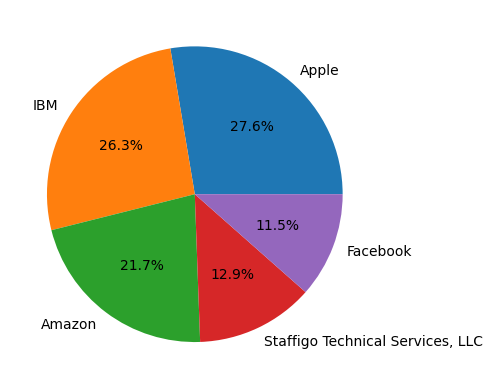

In [9]:
# Top companies (look at 'Company Name' column). Generate a plot to visualize top 5 companies based on the number of job postings.
top_companies_dict = df["company name"].value_counts().to_dict()
labels = list(top_companies_dict.keys())[:5]  # + ["Others"]
sizes = list(top_companies_dict.values())[:5]  # + [sum(list(top_companies_dict.values())[5:])]
gig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
print("Here is a pie chart that shows the distribution of the top 5 companies posting jobs in the dataset:")
plt.show()

Here is a pie chart that shows the distribution of the top 5 industries with jobs being posted in the dataset:


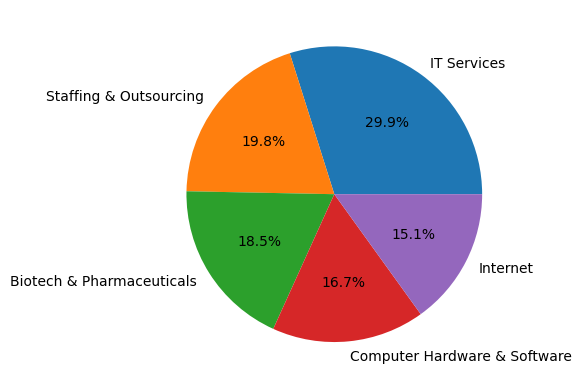

In [10]:

# Top Industry (look at 'Industry' column). Generate a plot to visualize top 5 industries based on the number of job postings linked to that industry.
top_industries_dict = df["industry"].value_counts().to_dict()
labels = list(top_industries_dict.keys())[:5]  # + ["Others"]
sizes = list(top_industries_dict.values())[:5]  # + [sum(list(top_industries_dict.values())[5:])]
gig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
print("Here is a pie chart that shows the distribution of the top 5 industries with jobs being posted in the dataset:")
plt.show()

### 3.2 Salary Analysis
Distribution, central tendency, and top-paying job titles. Print out the mean, median and mode for job salaries. Generate a plot that shows salary distribution (this can be done for all positions collectively).

In [11]:
n = 10
print(f"Top {n} job titles by mean of posted salary range:")
top_paying_jobs = df.groupby(by='cleaned job title')['average annual salary estimate'].mean().reset_index().sort_values(by='average annual salary estimate', ascending=False)
top_paying_jobs.head(n)

Top 10 job titles by mean of posted salary range:


,cleaned job title,average annual salary estimate
478,Data Scientist Machine Learning at Google,225000.0
897,Principal Data Scientist-Recommendation Systems,225000.0
825,NLP Data Scientist,225000.0
1237,Senior/Staff Software Engineer,225000.0
1153,Senior Data Scientist/Analyst,225000.0
1174,Senior HR Data Analyst,225000.0
1268,Staff Data Engineer,225000.0
243,Community Data Manager,225000.0
526,Data science researcher,225000.0
828,NLP Machine Learning Engineer,205000.0


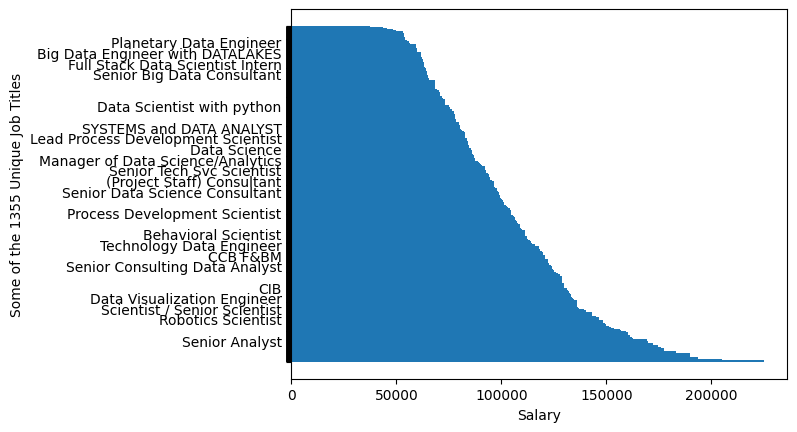

<Figure size 1200x1200 with 0 Axes>

In [12]:
labels = [jt for jt in top_paying_jobs['cleaned job title'].tolist()]
data = top_paying_jobs['average annual salary estimate'].tolist()
plt.barh(y=labels, width=data, height=1.5)
ax = plt.gca()
plt.xlabel("Salary")
plt.ylabel(f"Some of the {df['cleaned job title'].unique().__len__()} Unique Job Titles")
for i, label in enumerate(ax.get_yaxis().get_ticklabels()):
    if i % 43 != 0 or len(label.get_text()) > 35:
        label.set_visible(False)
    else:
        label.set_visible(True)
plt.figure(figsize=(12, 12))
plt.show()

Boxplot of Estimated Annual Salaries:


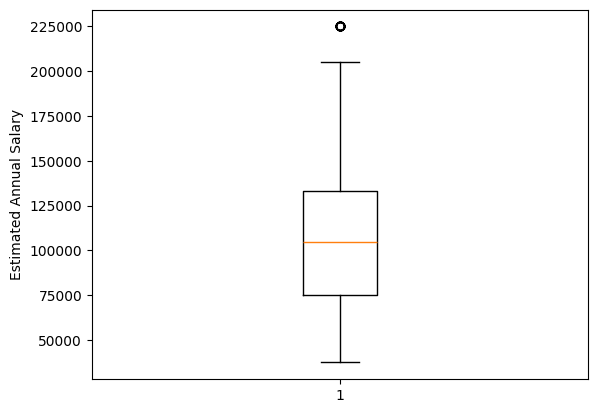

Mean: 108033
Median: 104500
Mode: 68500


In [13]:
plt.boxplot(x=df['average annual salary estimate'].tolist())
ax = plt.gca()
ax.set_ylabel("Estimated Annual Salary")
print("Boxplot of Estimated Annual Salaries:")
plt.show()
print("Mean:", int(df['average annual salary estimate'].mean()))
print("Median:", int(df['average annual salary estimate'].median()))
print("Mode:", int(df['average annual salary estimate'].mode().tolist()[-1]))

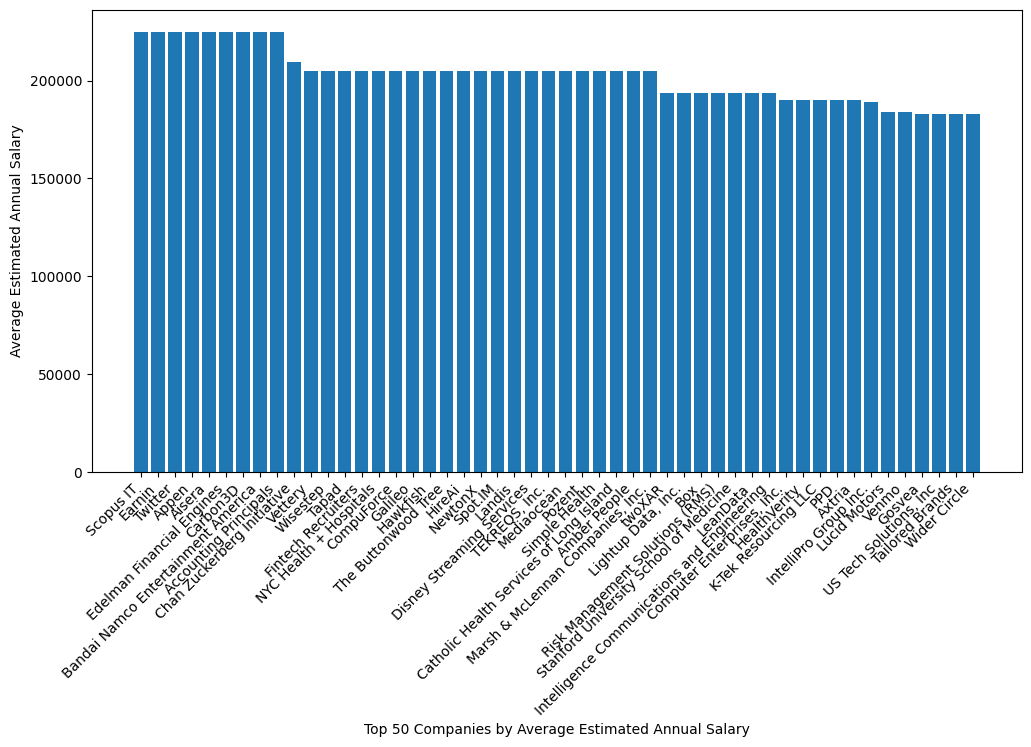

In [14]:
n = 50
plt.figure(figsize=(12, 6))
top_paying_companies = df.groupby(by='company name')['average annual salary estimate'].mean().reset_index().sort_values(by='average annual salary estimate', ascending=False)
plt.bar(x=top_paying_companies.head(n)['company name'], height=top_paying_companies.head(n)['average annual salary estimate'])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.set_ylabel("Average Estimated Annual Salary")
ax.set_xlabel(f"Top {n} Companies by Average Estimated Annual Salary")
plt.show()

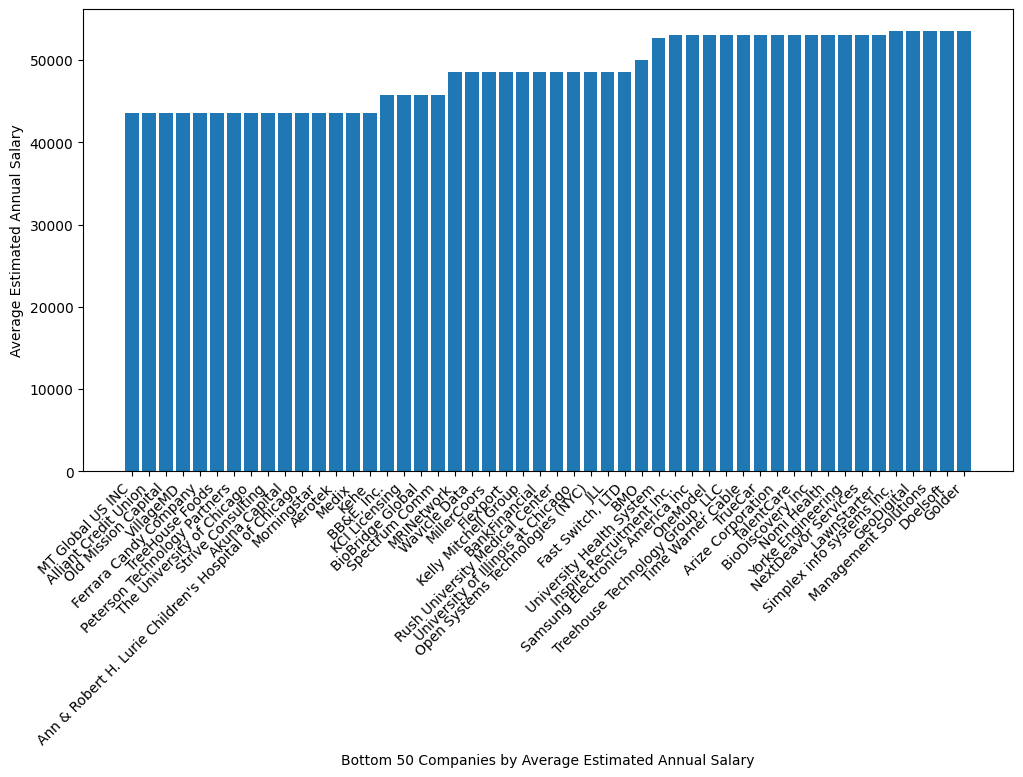

In [15]:
n = 50
plt.figure(figsize=(12, 6))
lowest_paying_companies = df.groupby(by='company name')['average annual salary estimate'].mean().reset_index().sort_values(by='average annual salary estimate', ascending=True)
plt.bar(x=lowest_paying_companies.head(n)['company name'], height=lowest_paying_companies.head(n)['average annual salary estimate'])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.set_ylabel("Average Estimated Annual Salary")
ax.set_xlabel(f"Bottom {n} Companies by Average Estimated Annual Salary")
plt.show()

We notice a large difference in salaries based on the company names, but not much of a difference between job titles.
The job title "data scientist" can have salaries ranging from 80k to 200k.
This is probably because salaries depend largely on job level and company revenues.
Some companies cannot afford to pay their eployees market rate, while others can beat it.
In other cases, different companies can use the same job title to reflect different job levels.

### 3.3 Remote vs. In-Person Jobs

Some job descriptions note that 'Work Remotely: Yes' which we can assume means this position is fully remote. Lets compare salary ranges for remote vs in-person positions for equivalent job titles.

You don't need to do this for all job titles, but select a few job titles that have a remote and in-person postings and compare their salary range.

Note, it will probably help to first create a new column that denotes if a posting is a remote or in-person job by parsing the job description for hints about remote work.

In [16]:
def is_remote(s):
    """if "remote" exists in description, make sure "not" does not appear before it in the same sentence. if remote is not mentioned, assume in person."""
    s = s.replace("\n", " ").replace(",", " ").replace("/", " ").replace("-", " ").replace(":", " ")
    sentences = s.split(". ")
    for sentence in sentences:
        rw = ["remote", "remotely"]
        for r in rw:
            ssl = sentence.lower().split(" ")
            if r in ssl:
                if ("not" in ssl and ssl.index("not") < ssl.index(r)):
                    return False
                else:
                    return True
    return False

df['remote'] = df.apply(lambda x: is_remote(x['job description']) or is_remote(x['job title']), axis=1)

C:\Users\kulka\AppData\Local\Temp\ipykernel_9076\935289736.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['remote'] = df.apply(lambda x: is_remote(x['job description']) or is_remote(x['job title']), axis=1)


In [17]:
print(f"In-person/hybrid job roles earn {-round(df[df['remote'] == True]['average annual salary estimate'].mean()) + round(df[df['remote'] == False]['average annual salary estimate'].mean())} more on average than remote roles.")

pd.DataFrame(data={"is remote": [True, False],
                   "average annual salary estimate": [round(df[df['remote'] == True]['average annual salary estimate'].mean()), round(df[df['remote'] == False]['average annual salary estimate'].mean())],
                   "number of postings": [round(df[df['remote'] == True]['average annual salary estimate'].__len__()), round(df[df['remote'] == False]['average annual salary estimate'].__len__())]
                  })

In-person/hybrid job roles earn 11131 more on average than remote roles.


,is remote,average annual salary estimate,number of postings
0,True,97908,353
1,False,109039,3556


We see that there are over 10x the number of in-person/hybrid jobs as there are remote jobs. Furthermore, remote roles earn on average 11k less, which may be because employees will inevitably have less travel expenses.

### 3.4 Location Distribution
Top locations and salary comparisons across locations.

- Perform analysis and visualize job postings by location. What are your findings?
- Visualize salary (for equivalent positions) by location. What are your findings?

In [18]:
df_city = df[["location", "average annual salary estimate"]].groupby("location").mean().reset_index().sort_values('average annual salary estimate')

In [19]:
n = 10
print(f"Top {n} cities by average pay:")
df_city.tail(n).sort_values('average annual salary estimate', ascending=False)

Top 10 cities by average pay:


,location,average annual salary estimate
135,"Queens Village, NY",205000.00
140,"Rockville Centre, NY",205000.00
161,"Stanford, CA",193500.00
114,"Newark, CA",175700.00
91,"Los Gatos, CA",171750.00
86,"Livermore, CA",170125.00
46,"Duarte, CA",170000.00
154,"Sherman Oaks, CA",170000.00
137,"Redwood City, CA",169718.75
133,"Port Washington, NY",169500.00


In [20]:
n = 10
print(f"Bottom {n} cities by average pay:")
df_city.head(n)

Bottom 10 cities by average pay:


,location,average annual salary estimate
50,"Elmhurst, IL",43500.0
110,"Naperville, IL",43500.0
96,"Maywood, IL",43500.0
141,"Rolling Meadows, IL",43500.0
28,"Cedar Park, TX",53500.0
51,"Evanston, IL",55750.0
153,"Seal Beach, CA",56000.0
92,"Luke AFB, AZ",60000.0
58,"Fort Sam Houston, TX",60565.0
9,"Bedford, TX",61500.0


In [21]:
df_city_ = df_city.copy()
df_city_["state"] = df_city_['location'].apply(lambda x: x.split(', ')[-1])
df_state = df_city_[["state", "average annual salary estimate"]].groupby("state").mean().reset_index().sort_values('average annual salary estimate')

In [22]:
n = 10
print(f"Top {n} states by average pay:")
df_state.tail(n).sort_values('average annual salary estimate', ascending=False)

Top 10 states by average pay:


,state,average annual salary estimate
6,NY,159996.012101
1,CA,134102.411831
2,DE,133550.000000
5,NJ,125759.126984
10,United Kingdom,99625.000000
8,PA,98439.769789
0,AZ,95295.306714
7,OH,95019.423559
9,TX,92753.581549
3,FL,87522.058824


In [23]:
n = 10
print(f"Bottom {n} states by average pay:")
df_state.head(n)

Bottom 10 states by average pay:


,state,average annual salary estimate
4,IL,77430.681818
3,FL,87522.058824
9,TX,92753.581549
7,OH,95019.423559
0,AZ,95295.306714
8,PA,98439.769789
10,United Kingdom,99625.000000
5,NJ,125759.126984
2,DE,133550.000000
1,CA,134102.411831


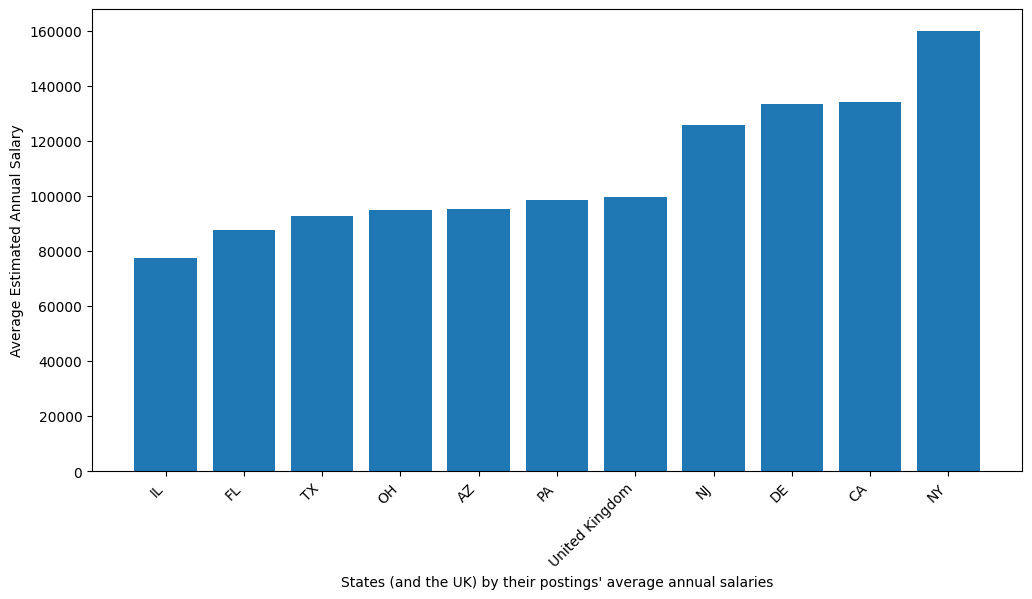

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(x=df_state['state'], height=df_state['average annual salary estimate'])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.set_ylabel("Average Estimated Annual Salary")
ax.set_xlabel(f"States (and the UK) by their postings' average annual salaries")
plt.show()

It is fairly clear that the location a role is based in has a massive impact on the salary. This is probably primarily because of high cost of living in these specific areas, but that may also lead these job roles to be more selective in its candidates, leading to perhaps a more qualified work force as well.

From the given data, we see that of the top 10 cities by pay, 7 of them are in California and 3 are from New York.

Upon grouping the data by state, we see that NY is the highest paid state, followed by CA, DE and NJ.

Our lowest paid state is Illinois by a significant margin, possibly due to low costs of living, but maybe also due to the size of the companies based out of the state.

In [25]:
df_job_loc = df[["location", "average annual salary estimate", "cleaned job title"]].groupby(by=['location', 'cleaned job title']).mean().reset_index().sort_values('average annual salary estimate')
df_job_loc['state'] = df_job_loc['location'].apply(lambda x: x.split(', ')[-1])
jt = "Data Scientist"
print(f"Average annual salary estimates for the title '{jt}', grouped by location:")
df_job_loc[df_job_loc['cleaned job title'] == jt]

Average annual salary estimates for the title 'Data Scientist', grouped by location:


,location,cleaned job title,average annual salary estimate,state
1738,"Rolling Meadows, IL",Data Scientist,43500.000000,IL
1269,"Naperville, IL",Data Scientist,43500.000000,IL
709,"Elmhurst, IL",Data Scientist,43500.000000,IL
1086,"Lewisville, TX",Data Scientist,61500.000000,TX
786,"Grapevine, TX",Data Scientist,61500.000000,TX
...,...,...,...,...
254,"Carrollton, TX",Data Scientist,172000.000000,TX
757,"Fremont, CA",Data Scientist,182166.666667,CA
2138,"Stanford, CA",Data Scientist,193500.000000,CA
1699,"Queens Village, NY",Data Scientist,205000.000000,NY


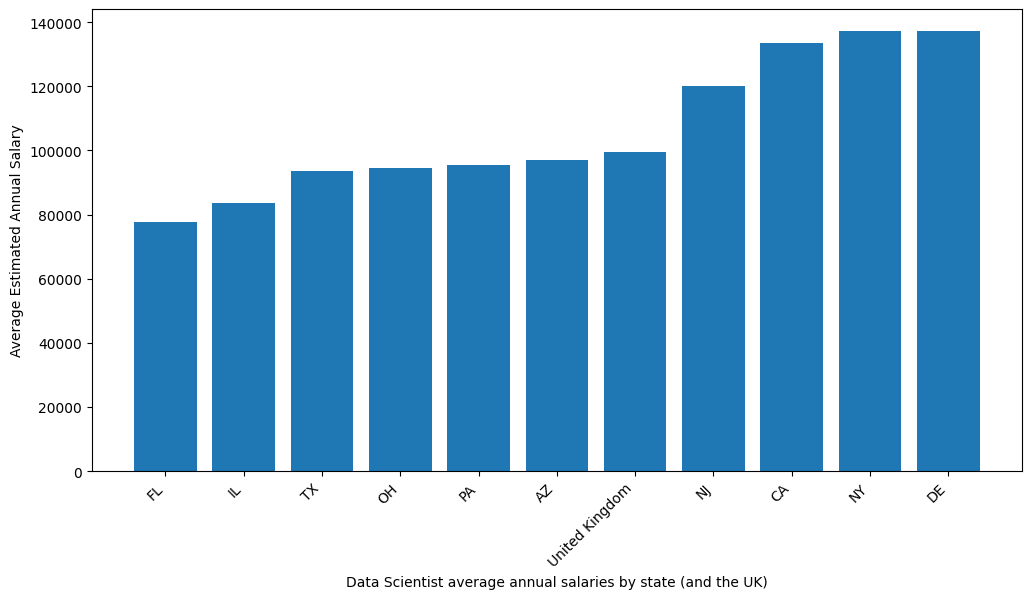

In [26]:
df_job_state = df_job_loc[['average annual salary estimate', 'state']].groupby('state').mean().reset_index().sort_values('average annual salary estimate')

plt.figure(figsize=(12, 6))
plt.bar(x=df_job_state['state'], height=df_job_state['average annual salary estimate'])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.set_ylabel("Average Estimated Annual Salary")
ax.set_xlabel(f"Data Scientist average annual salaries by state (and the UK)")
plt.show()

Even for the same job title 'Data Scientist', we see an extreme variance in salaries--ranging from 43k all the way up to 200k. The obvious factor for the discrepancy in the above data is the location, but other hidden factors such as different job level systems in different companies must definitely play a role in these massive differences.

### 3.5 Skills Analysis

To make this part easier, focus on the 'Data Scientist' job title.

Count frequency of tools/skills across job postings (ex. Hadoop, Spark, Python, R, Tableau, BigData, Pytorch, etc.). What technology / skills should I be teaching in my DS courses to meet the demand from industry?

You can parse the job description and look for specific skills / tools. Consider creating new columns that denote whether a job posting explicitly mentions that skill set. You can then use these columns to evaluate which skills / tools are sought out in industry.

In [27]:
df_datasci = df[df['cleaned job title'] == "Data Scientist"]

skill_dictionary = [
    # --- Programming Languages ---
    "Python", "R", "Scala", "Java", "Julia", "SQL", "C++", "C#", "Go", "Bash",

    # --- Big Data & Distributed Systems ---
    "Hadoop", "MapReduce", "Hive", "Pig", "Spark", "Flink", "Kafka", "Storm",
    "HBase", "Cassandra", "Elasticsearch", "Presto", "Trino", "Delta Lake",
    "Snowflake", "Databricks", "BigQuery", "Amazon EMR", "AWS Glue",

    # --- Data Engineering & Pipelines ---
    "Airflow", "Luigi", "Prefect", "Dagster", "dbt", "NiFi", "Talend",
    "Informatica", "Azure Data Factory", "Google Dataflow", "Kinesis",

    # --- Databases ---
    "PostgreSQL", "MySQL", "MongoDB", "SQLite", "Oracle", "Redshift",
    "DynamoDB", "Neo4j", "InfluxDB", "BigTable", "Snowflake", "Vertica",

    # --- Machine Learning / Deep Learning ---
    "TensorFlow", "Keras", "PyTorch", "Scikit-learn", "XGBoost", "LightGBM",
    "CatBoost", "MXNet", "ONNX", "HuggingFace Transformers", "FastAI",
    "OpenCV", "spaCy", "NLTK", "Gensim",

    # --- AI & Generative AI ---
    "LangChain", "LlamaIndex", "OpenAI API", "Hugging Face", "Stable Diffusion",
    "Whisper", "Diffusers", "Transformers", "AutoGPT", "DeepSpeed", "Ray",

    # --- Data Visualization ---
    "Tableau", "Power BI", "Looker", "Google Data Studio", "Matplotlib",
    "Seaborn", "Plotly", "Dash", "Bokeh", "Altair", "ggplot2",

    # --- Cloud Platforms ---
    "AWS", "Azure", "Google Cloud", "GCP", "IBM Cloud", "Oracle Cloud",
    "Snowflake", "Databricks", "Cloudera", "DataBricks",

    # --- Data Science / Analytics Tools ---
    "Jupyter", "Colab", "Excel", "NumPy", "Pandas", "SciPy", "StatsModels",
    "Matlab", "SAS", "Stata", "RapidMiner", "KNIME",

    # --- DevOps / Containerization / Deployment ---
    "Docker", "Kubernetes", "Terraform", "Jenkins", "GitHub Actions",
    "MLflow", "Kubeflow", "DVC", "Airflow", "Streamlit", "Gradio", "Flask", "FastAPI",

    # --- Business Intelligence / ETL / Reporting ---
    "Tableau", "Power BI", "QlikView", "Looker", "Data Studio", "MicroStrategy",
    "SAP BW", "Cognos Analytics",

    # --- Version Control & Collaboration ---
    "Git", "GitHub", "GitLab", "Bitbucket",

    # --- MLOps / Model Serving ---
    "MLflow", "Seldon", "TensorFlow Serving", "BentoML", "Ray Serve",
    "Weights & Biases", "Comet.ml", "Neptune.ai",

    # --- Operating Systems / Environments ---
    "Linux", "Unix", "Windows", "MacOS",

    # --- Others / Supporting Tools ---
    "BeautifulSoup", "Scrapy", "Requests", "PySpark", "DuckDB",
    "Parquet", "Avro", "ORC", "JSON", "YAML", "Feather", "Arrow"
]

def skill_matcher(desc):
    skills = []
    desc = " " + desc.replace("\n", " ").replace(",", " ").replace("/", " ").replace("-", " ").replace(":", " ").lower() + " "
    for skill in skill_dictionary:
        ns = " " + skill.replace("\n", " ").replace(",", " ").replace("/", " ").replace("-", " ").replace(":", " ").lower() + " "
        if ns in desc:
            skills.append(skill)
    return skills

df_datasci['skills'] = df['job description'].apply(skill_matcher)
df_datasci[['cleaned job title', 'company name', 'skills']]

C:\Users\kulka\AppData\Local\Temp\ipykernel_9076\4165296572.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_datasci['skills'] = df['job description'].apply(skill_matcher)


,cleaned job title,company name,skills
1,Data Scientist,Noom US,"[Python, SQL, Pandas]"
5,Data Scientist,IFG Companies,"[Python, R, SAS]"
10,Data Scientist,Quartet Health,"[Python, SQL, TensorFlow, Keras, Scikit-learn,..."
12,Data Scientist,Medidata Solutions,"[Python, Git]"
13,Data Scientist,Point72,"[Python, R, Scala, SQL, Spark]"
...,...,...,...
3746,Data Scientist,CAS,"[Python, SQL, Hadoop, Hive, Spark]"
3750,Data Scientist,Kognetics,"[Python, R, Scala, Java, SQL, Linux]"
3755,Data Scientist,Immuta,"[Python, SQL, Go, Spark, Tableau, Power BI, Lo..."
3759,Data Scientist,"Avacend, Inc.","[Python, R, Scala, Java, SAS, Stata]"


In [28]:
skill_dist = pd.DataFrame(columns=["skill", "number of postings"])
for skill in skill_dictionary:
    skill_dist.loc[len(skill_dist)] = [skill, (df_datasci['skills'].apply(lambda x: skill in x)).sum()]
skill_dist.sort_values('number of postings', ascending=False)

,skill,number of postings
0,Python,323
1,R,249
5,SQL,229
14,Spark,108
3,Java,77
...,...,...
152,DuckDB,0
155,ORC,0
157,YAML,0
158,Feather,0


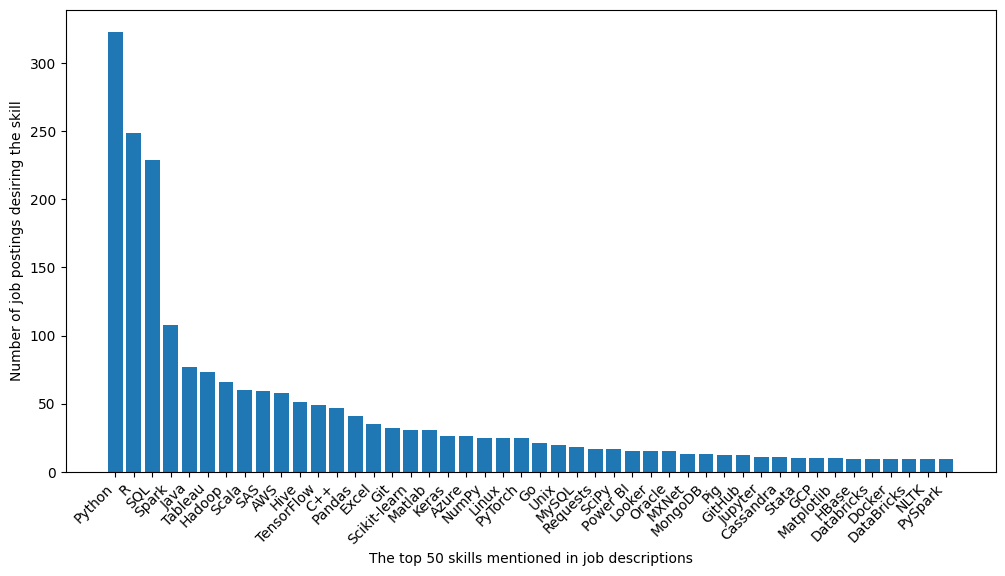

In [29]:
df_skills_plot = skill_dist[skill_dist['number of postings'] > 0].sort_values('number of postings', ascending=False).head(50)
plt.figure(figsize=(12, 6))
plt.bar(x=df_skills_plot['skill'], height=df_skills_plot['number of postings'])
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.set_ylabel("Number of job postings desiring the skill")
ax.set_xlabel(f"The top 50 skills mentioned in job descriptions")
plt.show()

From the above plot, it's clear that Python is an exremely important skill to have. Of the 418 Data Scientist job postings, over 300 have mentioned Python in the job description. Other notable skills are R, SQL, Spark, etc.

### 3.6 Analysis
Is there any correlation between the type of  industry and the number of jobs and the salary range for those jobs? Generate some plots.

In [30]:
industry_df = df[['industry', 'average annual salary estimate']].groupby('industry').agg(
    average_annual_salary_estimate=('average annual salary estimate', 'mean'),
    number_of_postings=('average annual salary estimate', 'size')
).reset_index().sort_values(['number_of_postings', 'average_annual_salary_estimate'], ascending=False)

In [31]:
n = 10
print(f"Top {n} industries by average salary:")
industry_df.sort_values('average_annual_salary_estimate', ascending=False).head(n)

Top 10 industries by average salary:


,industry,average_annual_salary_estimate,number_of_postings
8,Beauty & Personal Accessories Stores,176000.000000,1
20,Consumer Electronics & Appliances Stores,156500.000000,4
85,Transportation Equipment Manufacturing,143772.727273,11
41,Grantmaking Foundations,134000.000000,2
16,Commercial Equipment Rental,133000.000000,1
93,Video Games,131933.333333,30
38,Food Production,131500.000000,2
52,Internet,131295.462185,238
47,Home Furniture & Housewares Stores,130000.000000,1
45,Health Fundraising Organizations,130000.000000,1


In [32]:
n = 10
print(f"Bottom {n} industries by average salary:")
industry_df.sort_values('average_annual_salary_estimate', ascending=True).head(n)

Bottom 10 industries by average salary:


,industry,average_annual_salary_estimate,number_of_postings
62,"Museums, Zoos & Amusement Parks",62000.000000,1
74,Self-Storage Services,62500.000000,1
39,Gambling,65250.000000,2
71,Religious Organizations,71000.000000,1
23,Convenience Stores & Truck Stops,72500.000000,2
32,Fast-Food & Quick-Service Restaurants,75500.000000,2
75,Shipping,77500.000000,1
24,Cruise Ships,79000.000000,2
55,Legal,81857.142857,7
30,Express Delivery Services,82500.000000,2


Personally, I'm extremely surprised by the results of the average salaries by industry. In the top, we have Beauty and Consumer Electronics stores, and in the bottom, we have museums zoos, self-storage, and gambling. Personally, I would've guessed the Gambling and Religious Organizations would be higher, and I definitely would have assumed that the tech industry would be at the very top.

In [33]:
n = 10
print(f"Top {n} industries by number of postings:")
industry_df.sort_values('number_of_postings', ascending=False).head(n)

Top 10 industries by number of postings:


,industry,average_annual_salary_estimate,number_of_postings
48,IT Services,104817.288136,472
79,Staffing & Outsourcing,100485.623003,313
9,Biotech & Pharmaceuticals,110174.880546,293
17,Computer Hardware & Software,123677.121212,264
52,Internet,131295.462185,238
44,Health Care Services & Hospitals,99072.081218,197
19,Consulting,97387.108434,166
29,Enterprise Software & Network Solutions,111486.666667,150
53,Investment Banking & Asset Management,106380.733945,109
1,Advertising & Marketing,116989.247312,93


In [34]:
n = 10
print(f"Bottom {n} industries by number of postings:")
industry_df.sort_values('number_of_postings', ascending=True).head(n)

Bottom 10 industries by number of postings:


,industry,average_annual_salary_estimate,number_of_postings
71,Religious Organizations,71000.0,1
88,Truck Rental & Leasing,92500.0,1
8,Beauty & Personal Accessories Stores,176000.0,1
16,Commercial Equipment Rental,133000.0,1
83,Telecommunications Manufacturing,128000.0,1
77,Sporting Goods Stores,129000.0,1
45,Health Fundraising Organizations,130000.0,1
47,Home Furniture & Housewares Stores,130000.0,1
62,"Museums, Zoos & Amusement Parks",62000.0,1
74,Self-Storage Services,62500.0,1


Now this data makes a lot more sense. We have IT services, Staffing, Pharma, etc. at the top--most of the big industries we tend to think of.

At the bottom, we have more niche industries like Religious Orgs, Trucking, Beauty, etc. These industries probably do not need as many data scientists, and therefore the low number of postings make sense.

## Step 4: More EDA
Example: Compare salary trends across seniority inferred from job title (entry vs senior). For each job posting, characterize job as either senior, mid or entry. Then determine salary range for each postion. Generate a plot to show how salaries compare.

In [35]:
# TODO - Code goes here

entry_levels = ["jr", "junior", "entry", "intern", "apprentice", "assistantship", "1", "i"]
mid_levels = ["mts", "ii", "iii", "2", "3", "sr", "senior", "associate researcher"]
senior_levels = ["director", "lead", "principal", "president", "vp", "v.p.", "avp", "a.v.p.", "manager", "researcher"]

def level_decider(jt):
    for kw in senior_levels:
        if kw in jt.lower():
            return "Senior"
    for kw in mid_levels:
        if kw in jt.lower():
            return "Mid"
    for kw in entry_levels:
        if kw in jt.lower():
            return "Entry"
    return "Entry"

df['level'] = df['job title'].apply(level_decider)

C:\Users\kulka\AppData\Local\Temp\ipykernel_9076\1571748490.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'] = df['job title'].apply(level_decider)


In [36]:
df_level = df[['average annual salary estimate', 'level']].groupby('level').agg(
    average_annual_salary_estimate=('average annual salary estimate', 'mean'),
    number_of_postings=('average annual salary estimate', 'size'),
).reset_index()
df_level


,level,average_annual_salary_estimate,number_of_postings
0,Entry,107327.679516,2646
1,Mid,108329.856459,836
2,Senior,111828.430913,427


I found that entry, mid, and senior level postings all had exremely comparable salaries. This is probably because I failed to classify the job titles to a level properly, but after hours of tinkering I was unable to find any very good patterns to follow based on just the job title. Looking at the job description for the years of experience required would be a foolproof way of categorizing the jobs perfectly, but the problem statement asked us to use seniority inferred from job title.

## Step 5: Reflection

**Challenges faced:**

- The data contianed noisy and inconsistent rows, with pretty dirty job title fields, job description fields, and lacked a normalization of job levels which made inferring job levels quite challenging.
- The salary ranges were large for many postings, and since we didn't have any further data on the final salaries of these roles, the range average may not have been representative of the actual average salary for the role.
- I had to make the assumption that hourly workers worked for 8 hours a day and 260 days a year. This may or may not accurately represent the average employee in that role.

**Key findings:**

- There were clear differences in role salaries based on:
    - Location (city, state)
    - Industry
    - Company
- There were not-so-clear differences in salaries based on:
    - Seniority (likely due to classification errors)
    - Job title (my guess is because company and it's revenue/policies play a larger role in salaries than the title)
- There was a clear difference in the number of roles posted in different industries, and it was obvious which industries needed less Data Scientists than others.